# Ford GoBike Dataset Exploration
## by Andrew Ayman

## Investigation Overview

In this investigation, I wanted to look at the characteristics of bike trips that could be used to predict their Duration. The main focus was on the five variables of trips: Distance, Time, User Type,Bike Share and Gender.

## Dataset Overview

The data consisted of prices and attributes of approximately 54,000 round-cut diamonds. The attributes included the four Cs of diamonds, as well as additional measurements such as table, depth, and dimensions. Thirty-nine data points were removed from the analysis due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bikes=pd.read_csv('./Ford GoBike.csv')
bikes.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [3]:
# making the time columns into datetime to make future me work easy with dates
bikes['start_time']=pd.to_datetime(bikes['start_time'])
bikes['end_time']=pd.to_datetime(bikes['end_time'])

In [4]:
# Creating a distance column depending on the longitude and latitude
def haversine(df):
    """
    Calculate the distance in kilometers between two points on  earth
    
    Parameters:
      Dataframe with (lon1, lat1, lon2, lat2) as columns in that order
    """

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    r = 6371
    return c * r
  
bikes['distance']=haversine(bikes[['start_station_longitude','start_station_latitude','end_station_longitude','end_station_latitude']])
bikes['distance'].head()

0    0.544709
1    1.742999
2    2.704545
3    0.260739
4    2.409301
Name: distance, dtype: float64

In [5]:
def remove_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Getting the DataFrame and the column name then filter the data from outliers based on this column
    """
    #Getting the Q1 and Q3 using the quantile method providing the percentage we want
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)
    IQR = Q3 - Q1
    #Quering the dataframe based on the conditions we said then returning the dataframe
    return df.query(f"{col}>{Q1-1.5*IQR} and {col}<{Q3+1.5*IQR}")

bikes=remove_outliers(bikes,'duration_sec')


In [6]:
#Quering the birth year larger than the 1940s 
bikes=bikes.query('member_birth_year >= 1940')


## Duration Distribution
Trip durations in the dataset take on a very large range of values, from about 50s at the lowest, to about 80,000s at the highest. Plotted after filtering the outliers, the distribution of trip durations takes on a unimodal shape.

We can see that the durations are Positively(right) Skewed cause mean > median > mode.<br>
meaning that most trips take approximately 300 seconds (roughly 5 minutes).<br>
The average trip duration is 550 seconds (roughly 9 minutes).

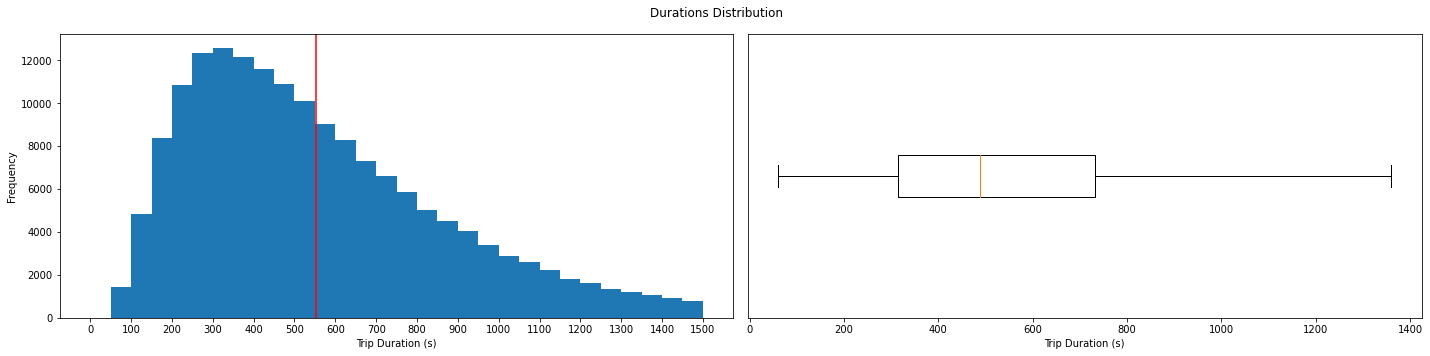

In [7]:
# making subplots to draw our two graphs, increaseing the figure size and providing a Title
fig, ax=plt.subplots(ncols=2,figsize=(20,5))
fig.suptitle('Durations Distribution')

# Drawing a histogram with bins specified to have 50 bin width to show more accurately the distribution then drawing a line indicating the mean
bins=np.arange(0,1500+50,50)
ax[0].hist(data=bikes,x='duration_sec',bins=bins)
ax[0].set_xlabel('Trip Duration (s)')
ax[0].set_ylabel('Frequency')
# Showing only x ticks of hundreds
ax[0].set_xticks(np.arange(0,1500+100,100))
ax[0].axvline(bikes['duration_sec'].mean(),color='r')

# Drawing a boxplot to show the quartiles of our data
ax[1].boxplot(data=bikes,x='duration_sec',vert=False,showfliers=False)
ax[1].set_xlabel('Trip Duration (s)')
ax[1].set_yticks([])

# To auto adjust the margins between thw two plots 
fig.tight_layout()

## Time affect on Duration

The hours ranges from 0 (midnight) => 23 (11pm) and days from 1<sup>st</sup> => 28<sup>th</sup> of the month of february 2019.<br>
First for the time of day as we can see the duration in the early hours are lower than at noon and early night cause traffic and other possible factors. <br>
The day of the month has nearly no affect on the duration of the trip<br>

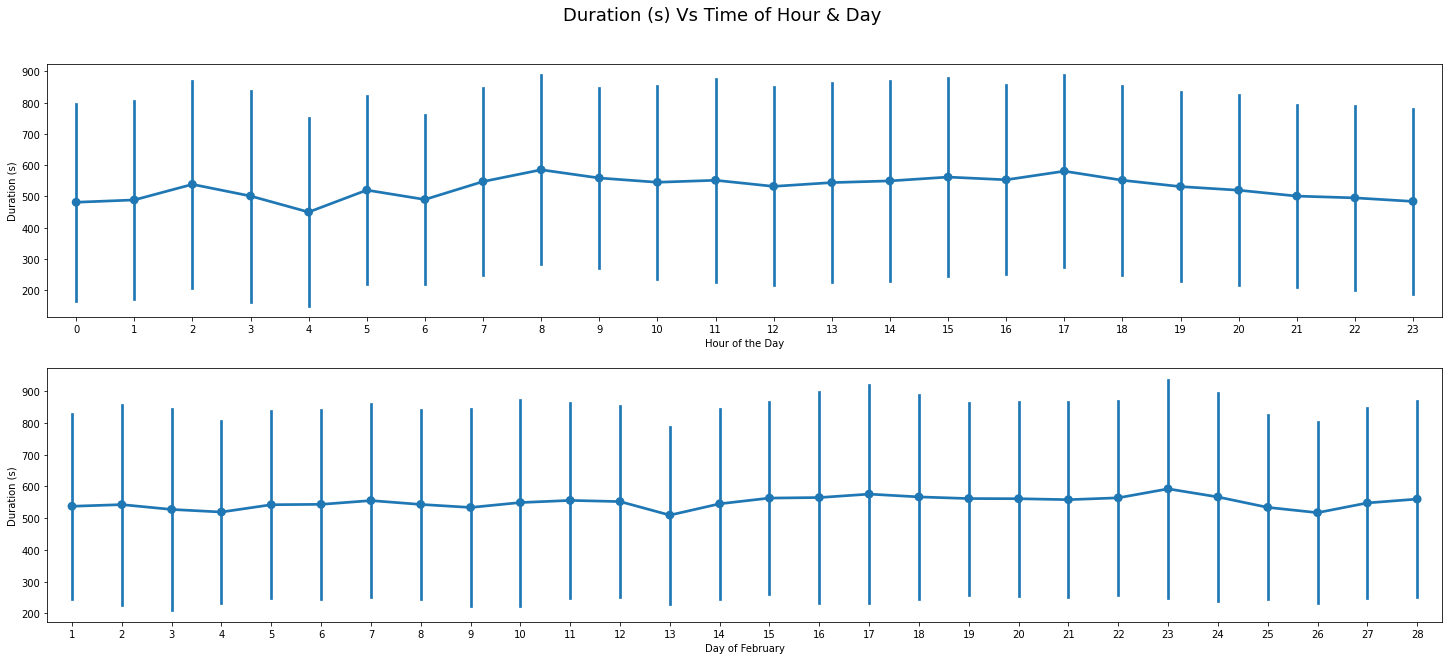

In [21]:
# First we extract the hours and days of each time
hours=bikes['start_time'].dt.hour
feb_days=bikes['start_time'].dt.day

# Making a subplot although plots of two rows and increasing figsize 
fig, ax = plt.subplots(nrows=2,figsize=(25,10))

# Plotting a point plot with the duration on the y-axis and the lines represent the std of the data
sb.pointplot(data=bikes,y='duration_sec',x=hours,ci='sd',ax=ax[0])
sb.pointplot(data=bikes,y='duration_sec',x=feb_days,ci='sd',ax=ax[1])

ax[0].set_xlabel('Hour of the Day')
ax[0].set_ylabel('Duration (s)')

ax[1].set_xlabel('Day of February')
ax[1].set_ylabel('Duration (s)')

fig.subplots_adjust(top=0.9) # To give a Padding to the title
fig.suptitle('Duration (s) Vs Time of Hour & Day',fontsize=18);

## Affect of Gender, Type, Bike Share on Duration 
We see that most subscribers take less time in traveling but they travel less distance so it balances out.<br> 
Most genders approximately take the same amount of time and travel same distance so gender is neutral in cycling.<br>
50% people who turn off the bike share take more time but they travels a further distance <br>


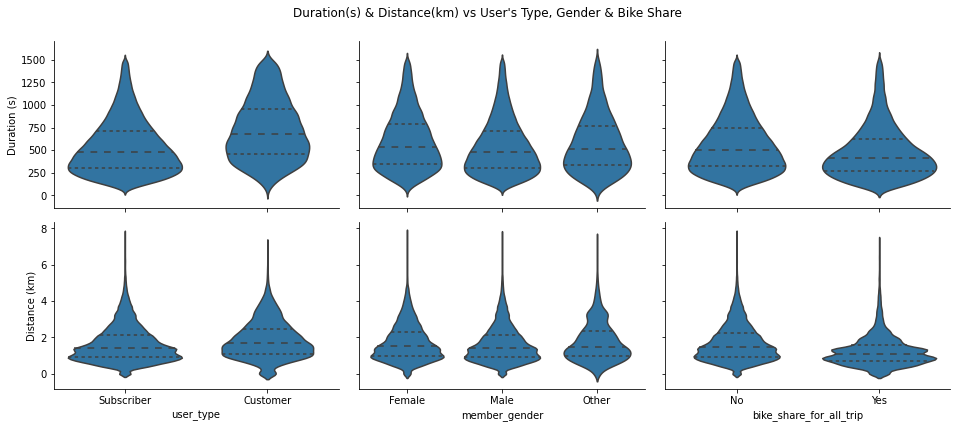

In [22]:
qualitative_vs = ['user_type', 'member_gender', 'bike_share_for_all_trip']
basic_color=sb.color_palette()[0]

# making a pairplot to plot a violin plot to view the relation we have
# Violin plot instead of box plot to view the distribution a lot better
g = sb.PairGrid(data = bikes, y_vars = ['duration_sec', 'distance'], x_vars = qualitative_vs,
                height = 3, aspect = 1.5)
g.map(sb.violinplot,inner='quartile',color=basic_color);

# Changing the y labels to accurately name the the y axis
g.axes[1][0].set_ylabel('Distance (km)')
g.axes[0][0].set_ylabel('Duration (s)');

g.fig.subplots_adjust(top=0.9) # To give a Padding to the title 
g.fig.suptitle('Duration(s) & Distance(km) vs User\'s Type, Gender & Bike Share');